C:\Users\2469l\AppData\Local\Temp\ipykernel_13960\3338057618.py:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target_index = np.int(target_time * sampling_frequency)


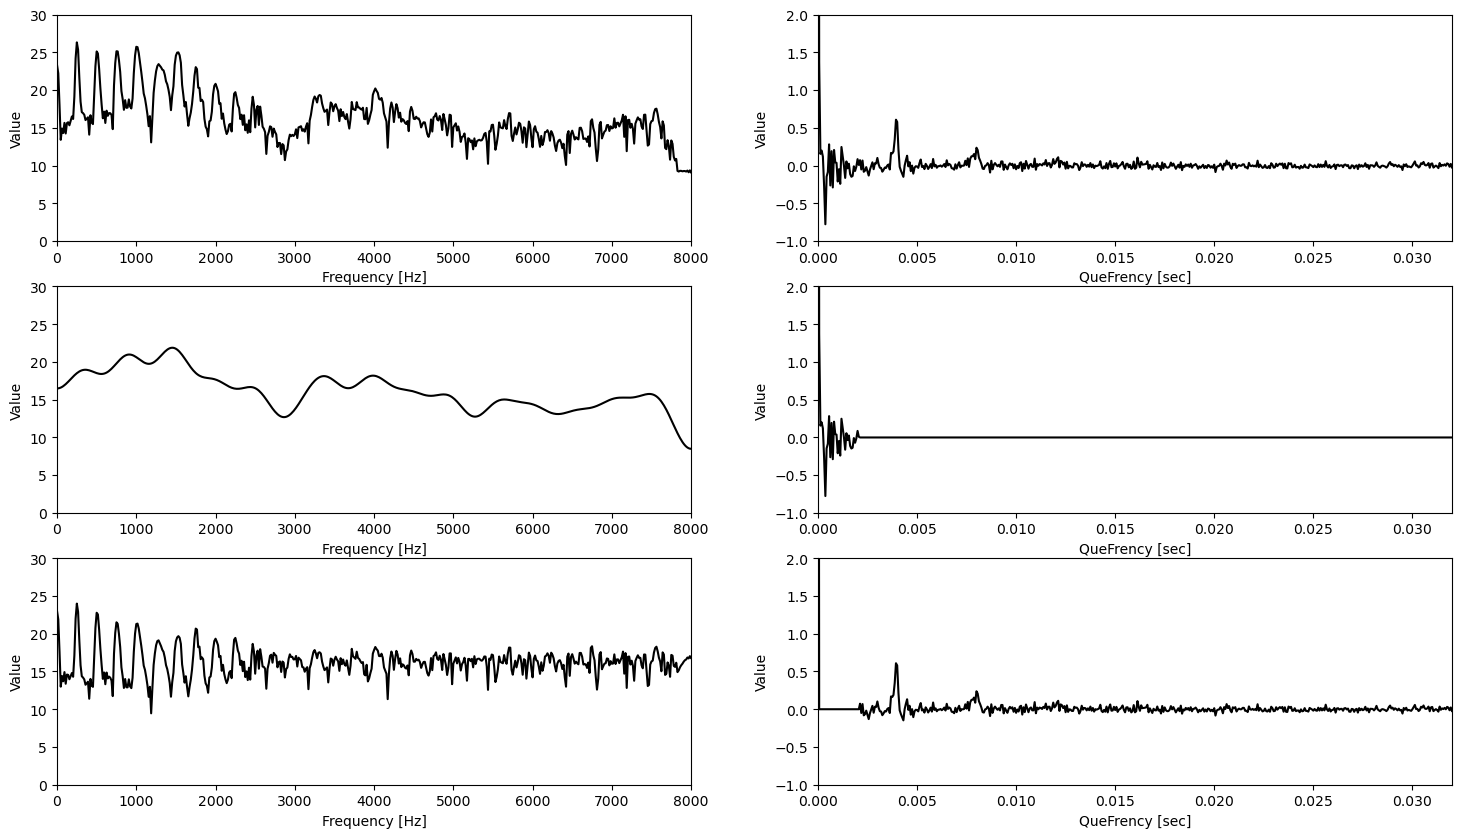

In [10]:
import wave
import numpy as np
import matplotlib.pyplot as plt

if __name__ =='__main__':
    #wav 경로파일
    wav_file = './data/wav/BASIC5000_0001.wav'
    
    #분석시간 : BASIC5000_0001.wav에서는
    # 아래 시각에서 음소 "o"을 발화함
    target_time = 0.58
    # 아래 시각에서 음소 "a"을 발화한다
    target_time= 0.73
    
    # FFT(고속 푸리에 변환)을 수행할 범위
    # 2의 제곱이어야 한다
    fft_size=1024
    
    #켑스트럼 저차와 고차 경계를 정하는 차수
    cep_threshold = 33
    
    #시각화 결과를 저장하는 파일 (png 파일)
    out_plot = './cepstrum.png'
    
    with wave.open(wav_file) as wav:
        
        sampling_frequency = wav.getframerate()
        waveform = wav.readframes(wav.getnframes())
        waveform = np.frombuffer(waveform, dtype=np.int16)
    
    target_index = np.int(target_time * sampling_frequency)
    
    #FFT를 실행하는 구간만큼의 파형 데이터 추출
    
    frame = waveform[target_index:target_index + fft_size].copy()
    
    # 해밍 창 함수를 적용
    frame = frame *np.hamming(fft_size)
    #로그 파워 스펙트럼 계산
    spectrum = np.fft.fft(frame)
    log_power = 2 * np.log(np.abs(spectrum) + 1E-7)
    
    #로그 파워 스펙트럼에 역푸리에 변환을 적용하여
    # 켑스트럼 값을 구한다
    
    cepstrum = np.fft.ifft(log_power)
    
    #켑스트럼 고차부분을 0으로 한다
    cepstrum_low = cepstrum.copy()
    cepstrum_low[(cep_threshold+1):-(cep_threshold)] = 0.0
    
    #고차 영역을 제거한후 켑스트럼을 다시 푸리에 변환하여
    #로그 파워 스펙트럼 계산
    log_power_ceplo = np.abs(np.fft.fft(cepstrum_low))
    
    #역으로 저차를 0으로 한 켑스트럼을 구한다
    cepstrum_high = cepstrum - cepstrum_low
    #단, 0차원은 제거하지 않는다
    cepstrum_high[0] =cepstrum[0]
    
    # 저차 영역을 제거한 켑스트럼을 다시 푸리에 변환하여
    # 로그 파워 스펙트럼 계산
    log_power_cephi = np.abs(np.fft.fft(cepstrum_high))
    
    # 시각화 그림 영역 지정
    plt.figure(figsize=(18,10))
    
    # 로그 파워 스펙트럼 x축(주파수축)을 생성한다
    freq_axis = np.arange(fft_size) *sampling_frequency / fft_size
    
    # 3가지 로그 파워 스펙트럼을 시각화한다
    for n, log_pow in enumerate([log_power, log_power_ceplo, log_power_cephi]):
        # 시각화 영역을 3행 2열로 분할하여 1열을 시각화
        plt.subplot(3, 2, n*2+1)
        plt.plot(freq_axis, log_pow, color='k')
        #x 축과 y축 라벨 정의
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Value')
        #표시 영역 제한
        plt.xlim([0, sampling_frequency /2])
        plt.ylim([0, 30])
        
    #켑스트럼 x축 (quefrency 축 = 시간축)을 생성한다
qefr_axis = np.arange(fft_size) / sampling_frequency
    
    # 3가지 켑스트럼 시각화
for n, cepst in enumerate([cepstrum, cepstrum_low, cepstrum_high]):
    plt.subplot(3,2, n*2+2)
        #켑스트럼 실수 부분 시각화
        # (허수부는 거의 0이다)
    plt.plot(qefr_axis, np.real(cepst), color='k')
        # x축과 y축 라벨 정의화
        
    plt.xlabel('QueFrency [sec]')
    plt.ylabel('Value')
        #표시영역 제한
    plt.xlim([0, fft_size / (sampling_frequency * 2)])
    plt.ylim([-1.0, 2.0])
    #그림을 저장한다

plt.savefig(out_plot)